<a href="https://colab.research.google.com/github/JingyuanWu17/DL/blob/master/GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


###Data Preprocessing

In [1]:
!pip install mtcnn

     |████████████████████████████████| 2.3MB 29.5MB/s 


In [2]:
import numpy as np
from os import listdir
from PIL import Image
from mtcnn.mtcnn import MTCNN

def load_image(filename):
    image = Image.open(filename)
    image = image.convert('RGB')
    img_pixels = np.asarray(image)
    return img_pixels

# extract face from loaded image by using MTCNN
def extract_face(model, img_pixels, size=(80, 80)):
    face = model.detect_faces(img_pixels)
    if len(face) == 0: return None

    x1, y1, width, height = face[0]['box']
    x1, y1 = abs(x1), abs(y1)
    x2, y2 = x1 + width, y1 + height
    face_pixels = img_pixels[y1:y2, x1:x2]

    face_img_resize = Image.fromarray(face_pixels).resize(size)
    return np.asarray(face_img_resize)

# load images and extract faces from directory
def load_faces(directory, n_faces):
    model = MTCNN()
    faces = []
    for filename in listdir(directory):
        # load image
        img_pixels = load_image(directory + filename)

        # extract face
        face = extract_face(model, img_pixels)
        if face is None: continue

        faces.append(face)
 
        if len(faces) >= n_faces: break

    return np.asarray(faces)

directory = '/content/drive/MyDrive/GAN/samples/'
faces = load_faces(directory, 20000)
print('faces shape: ', faces.shape)

# save file
np.savez_compressed('preprocessed_faces.npz', faces)

###Models

####Discriminator

In [3]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Dropout
from keras.optimizers import Adam

def discriminator_model(in_shape=(80,80,3)):
	model = Sequential()

	# normal, 80 x 80
	model.add(Conv2D(128, (5,5), padding='same', input_shape=in_shape))
	model.add(LeakyReLU(alpha=0.2))

	# downsample to 40 x 40
	model.add(Conv2D(128, (5,5), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))

	# downsample to 20 x 20
	model.add(Conv2D(128, (5,5), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))

	# downsample to 10 x 10
	model.add(Conv2D(128, (5,5), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))

	# downsample to 5 x 5
	model.add(Conv2D(128, (5,5), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))

	model.add(Flatten())
	model.add(Dropout(0.4))
	model.add(Dense(1, activation='sigmoid'))

	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

	return model

discriminator = discriminator_model()
discriminator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 80, 80, 128)       9728      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 80, 80, 128)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 40, 40, 128)       409728    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 40, 40, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 20, 20, 128)       409728    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 20, 20, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 10, 10, 128)       4

####Generator

In [4]:
def generator_model(latent_dim=100):
	model = Sequential()

	model.add(Dense(128 * 5 * 5, input_dim=latent_dim))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Reshape((5, 5, 128)))
 
	# upsample to 10 x 10
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
 
	# upsample to 20 x 20
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
 
	# upsample to 40 x 40
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
 
	# upsample to 80 x 80
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))

	model.add(Conv2D(3, (5,5), activation='tanh', padding='same'))
 
	return model

generator = generator_model()
generator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 3200)              323200    
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 3200)              0         
_________________________________________________________________
reshape (Reshape)            (None, 5, 5, 128)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 10, 10, 128)       262272    
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 10, 10, 128)       0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 20, 20, 128)       262272    
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 20, 20, 128)      

####GAN

In [5]:
def GAN_model(generator, discriminator):
	model = Sequential()
 
	# set discriminator's weights as non-trainable
	discriminator.trainable = False

	# add generator
	model.add(generator)
 
	# add discriminator
	model.add(discriminator)

	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt)
 
	return model

GAN = GAN_model(generator, discriminator)
GAN.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_1 (Sequential)    (None, 80, 80, 3)         1381891   
_________________________________________________________________
sequential (Sequential)      (None, 1)                 1651841   
Total params: 3,033,732
Trainable params: 1,381,891
Non-trainable params: 1,651,841
_________________________________________________________________


###Train

####Helper functions

In [6]:
import matplotlib.pyplot as plt

def load_prepocessed_faces():
	data = np.load('img_align_celeba.npz')
	X = data['arr_0'].astype('float32')
	X = (X - 127.5) / 127.5
	return X

def generate_latent_points(latent_dim, n_samples):
	X = np.random.randn(latent_dim * n_samples)
	X = X.reshape(n_samples, latent_dim)
	return X

# randomly select 'real' samples from dataset, and create 'real' class labels
def generate_real_training_set(dataset, n_samples):
	ix = np.random.randint(0, dataset.shape[0], n_samples)
	X = dataset[ix]
	y = np.ones((n_samples, 1))
	return X, y

# use generator to generate fake samples, and create 'fake' class labels
def generate_fake_training_set(g_model, latent_dim, n_samples):
	X = generate_latent_points(latent_dim, n_samples)
	X = generator.predict(X)
	y = np.zeros((n_samples, 1))
	return X, y


####Training

In [11]:
def train(generator, discriminator, GAN, dataset, latent_dim=100, n_epochs=100, batch_size=128):
	batch_per_epoch = int(dataset.shape[0] / batch_size)
	half_batch = int(batch_size / 2)

	d_losses_real = []
	d_losses_fake = []
	g_losses = []

	for i in range(n_epochs):
		d_losses_real_tmp = []
		d_losses_fake_tmp = []
		g_losses_tmp = []

		for j in range(batch_per_epoch):
			# get 'real' training set (half batch size)
			X_real, y_real = generate_real_training_set(dataset, half_batch)

			# update discriminator's weights via 'real' training set
			d_loss_real, _ = discriminator.train_on_batch(X_real, y_real)
			d_losses_real_tmp.append(d_loss_real)

			# get 'fake' training set (half batch size)
			X_fake, y_fake = generate_fake_training_set(generator, latent_dim, half_batch)

			# update discriminator's weights via 'fake' training set
			d_loss_fake, _ = discriminator.train_on_batch(X_fake, y_fake)
			d_losses_fake_tmp.append(d_loss_fake)

			# prepare latent points (batch size) as input for the GAN model
			X_gan = generate_latent_points(latent_dim, batch_size)

			# create inverted labels (batch size) for the GAN model
			y_gan = np.ones((batch_size, 1))

			# update generator's weight via discriminator's error
			g_loss = GAN.train_on_batch(X_gan, y_gan)
			g_losses_tmp.append(g_loss)

		d_losses_real.append(np.average(d_losses_real_tmp))
		d_losses_fake.append(np.average(d_losses_fake_tmp))
		g_losses.append(np.average(g_losses_tmp))

		# generate 'fake' images for every ten epochs
		if (i+1) % 10 == 0:
			print('epoch', i+1)
			X_fake, _ = generate_fake_training_set(generator, latent_dim, 100)
			X_fake = (X_fake + 1) / 2.0
			plt.figure()
			for i in range(100):
				plt.subplot(10, 10, i+1)
				plt.axis('off')
				plt.imshow(X_fake[i], cmap='gray_r')
			plt.show()
			
	return d_losses_real, d_losses_fake, g_losses

epoch 10


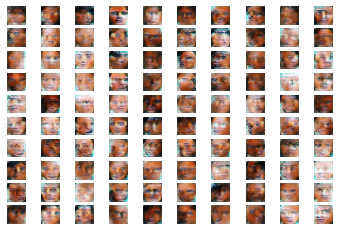

epoch 20


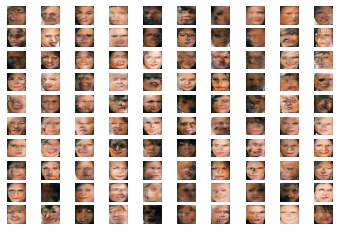

epoch 30


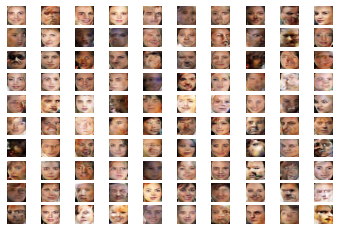

epoch 40


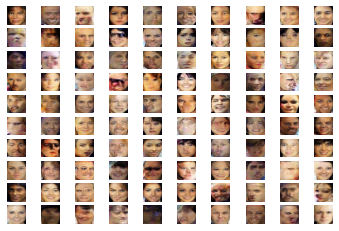

epoch 50


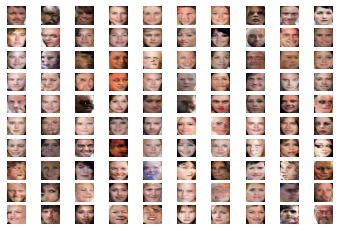

epoch 60


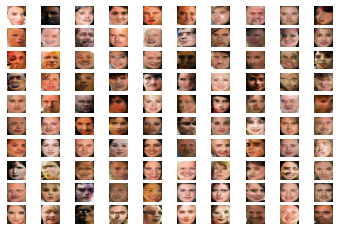

epoch 70


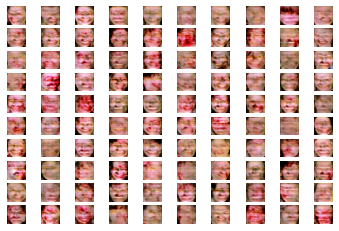

epoch 80


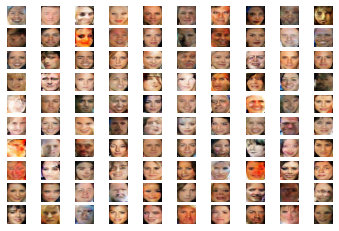

epoch 90


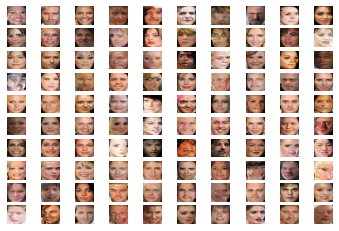

epoch 100


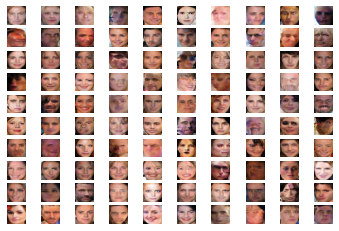

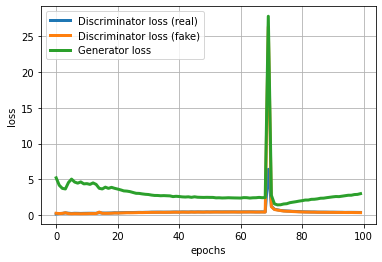

In [12]:
dataset = load_prepocessed_faces()
d_losses_real, d_losses_fake, g_losses = train(generator, discriminator, GAN, dataset)

plt.plot(range(100),d_losses_real,'-',linewidth=3,label='Discriminator loss (real)')
plt.plot(range(100),d_losses_fake,'-',linewidth=3,label='Discriminator loss (fake)')
plt.plot(range(100),g_losses,'-',linewidth=3,label='Generator loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.grid(True)
plt.legend()
plt.show()